# Travail pour analyser notre dataset, notre modèle et nos résultats

#### On récupère le fichier Kaggle

In [23]:
from bigml.api import BigML
from pandas import read_csv
import json

df = read_csv('csv_file/train_full.csv')
api = BigML(project='project/5d94a454eba31d46690001d1')

#### Envoi sur BigML

##### Création source et dataset pour pouvoir travailler sur BigML

In [24]:
# Creation d'une source
source = api.create_source('csv_file/train_full.csv')
api.ok(source)
# Creation d'un dataset ( = source )
origin_dataset = api.create_dataset(source)
api.ok(origin_dataset)

True

#### Split du dataset Train/Val

In [27]:
train_set = api.create_dataset(
    origin_dataset, {"name": "train_set",
                     "sample_rate": 0.8, "seed": "my seed"})
validation_set = api.create_dataset(
    origin_dataset, {"name": "validation_set",
                     "sample_rate": 0.8, "seed": "my seed",
                     "out_of_bag": True})

#### Création fichier csv des 2 sets qui serviront pour l'amélioration continue
- cf notebook : GiveMeCredit_ContinuousImprovement

In [33]:
from bigml.api import BigML
from pandas import read_csv

api.ok(train_set)
api.download_dataset(train_set, filename='csv_file/train_set.csv')
api.ok(validation_set)
api.download_dataset(validation_set, filename='csv_file/validation_set.csv')

'csv_file/validation_set.csv'

#### Création d'un modele ensemble sur la partie train du split du dataset TrainFull (On precise quelle est la donnée que l'on recherche)

In [ ]:
ensemble = api.create_ensemble(train_set , {"objective_field" : "SeriousDlqin2yrs"})
print("OK")

#### Récupération des données d'évaluation du modèle sur validation_set

In [ ]:
import pandas

evaluation = api.create_evaluation(ensemble, validation_set)
api.ok(evaluation)
%store evaluation
eval = pandas.DataFrame(evaluation["object"]["result"]["model"]["confusion_matrix"], index=["F", "P"], columns=["F", "P"])
print(eval)

#### Prédiction du modèle sur le validation_set 

In [ ]:
batch_prediction_validation_set = api.create_batch_prediction(ensemble, validation_set,{"header": True, "all_fields": True,"prediction_name": "my_prediction", "probability": True, "probabilities": True})
api.ok(batch_prediction_validation_set)
api.download_batch_prediction(batch_prediction_validation_set,filename='BatchPrediction/Validation_set_prediction.csv')

#### Création de la matrice de confusion

##### Cette matrice sert à diviser les prédictions en 4 catégories :
- Vrai positifs : le modèle a prédit 1 et a eu raison
- Vrai négatifs : le modèle a prédit 0 et a eu raison
- Faux positifs : le modèle a prédit 1 et s'est trompé
- Faux négatifs : le modèle a prédit 0 et s'est trompé

In [ ]:
import pandas

prediction = pandas.read_csv('BatchPrediction/Validation_set_prediction.csv')
prediction.describe()

In [ ]:
def matrix_confusion_method(row):
    x = "TN"
    if row['SeriousDlqin2yrs'] == 1:
        if row['my_prediction'] == 1:
            x = "TP"
        else:
            x = "FN"
    else:
        if row['my_prediction'] == 1:
            x = "FP"
    return x

#### Affichage des valeurs de la matrice de confusion

In [ ]:
def get_matrix_confusion():
    prediction['Error'] = prediction.apply(matrix_confusion_method, axis=1)
    return prediction['Error'].value_counts()

matrix_confusion = get_matrix_confusion()
print(matrix_confusion)

#### Calcul de l'accuracy de notre modèle

In [ ]:
accuracy = (matrix_confusion['TP'] + matrix_confusion ['TN'])/300
print(accuracy)

## Etapes du travail d'analyse d'erreurs  :
- créer colonne "erreur" : i.e. colonne où on décrit si c'est un FN, FP, TN, TP
- analyser les plus grosses erreurs (probability très proche de 1)

#### Mise en forme de notre fichier pour analyse des erreurs les plus importantes

##### Ici, on a décidé de sélectionner les 100 plus grosses erreurs du modèle :
- C'est-à-dire que le modèle a fait une prédiction avec une probabilité très importante (ou avec un taux de confiance très fort) mais la prédiction est mauvaise

In [ ]:
filtered = prediction.loc[prediction['Error'].isin(["FN", "FP"])]
filtered = (filtered.nlargest(100, 'probability'))

filtered.to_csv('csv_file/100mistakes.csv')
filtered.describe()

## Etapes de travail pour obtenir le seuil qui permet d'avoir le meilleur profit

#### Fonction qui crée la colonne de prédiction en fonction du seuil (threshold)

In [41]:
def threshold(row):
    if row['1 probability'] < threshold_value:
        prediction_value = 0
    else: 
        prediction_value = 1
    return prediction_value

#### Fonction qui crée la colonne "error" qui classe dans une des 4 catégories de la matrice de confusion

In [42]:
def error_column(row):
    if(row['SeriousDlqin2yrs'] == 0 and row['prediction'] == 0):
        error_value = 'TN'
    if(row['SeriousDlqin2yrs'] == 1 and row['prediction'] == 0):
        error_value = 'FN'
    if(row['SeriousDlqin2yrs'] == 0 and row['prediction'] == 1):
        error_value = 'FP'
    if(row['SeriousDlqin2yrs'] == 1 and row['prediction'] == 1):
        error_value = 'TP'
    return error_value

#### Fontion qui crée et définit la matrice des coûts

In [43]:
def get_profits():
    matrix = list(prediction.error.values)
    val_tn = 500
    val_fn = -2500
    val_tp = 0
    val_fp = -500
    profits = matrix.count('TN') * val_tn + matrix.count('FN') * val_fn + matrix.count('TP') * val_tp + matrix.count('FP') * val_fp
    return profits

#### Fonction qui calcule les coûts de chaque ligne en fonction de sa classe dans la matrice de confusion 

In [44]:
def cost_threshold(threshold):
    # Return True si 1 Proba > seuil & False si 1 Proba < seuil
    prediction_threshold = prediction['1 probability'] > threshold
    
    P_pred = prediction_threshold # Renvoie True si 1 proba > seuil ( sinon False )
    N_pred = ~prediction_threshold # Renvoie True si 1 proba < seuil ( sinon False )
    
    P_real = (prediction['SeriousDlqin2yrs'] == 1) # Renvoie True si SeriousDlqin2Yrs == 1 ( sinon False )
    N_real = (prediction['SeriousDlqin2yrs'] == 0) # Renvoie True si SeriousDlqin2Yrs == 0 ( sinon False )
    
    # P_pred True si 1 proba > seuil Prediction =  1 , P_real True si Realite = 1 
    TP = len(prediction.loc[P_pred & P_real])
    # N_pred True = si 1 proba < seuil = Prediction = 0 , N_real True si Realité 0 
    TN = len(prediction.loc[N_pred & N_real])
    # P_pred True si 1 proba > seuil Prediction = 1 , N_real True si Réalite = 0
    FP = len(prediction.loc[P_pred & N_real])
    # N_pred True si 1 proba < seuil =  Prediction 0 , P_real True si Realité = 1
    FN = len(prediction.loc[N_pred & P_real])
    
    TP_cost = 0
    FN_cost = -2500
    FP_cost = -500
    TN_cost = 500
    
    cost = TP * TP_cost
    cost += TN * TN_cost
    cost += FP * FP_cost
    cost += FN * FN_cost
    
    return cost

#### A partir de là, on peut créer le graphique qui calcule le profit pour chaque seuil et sortir le seuil qui donne le profit optimal

gain max 10040500 $ | Seuil 0.27


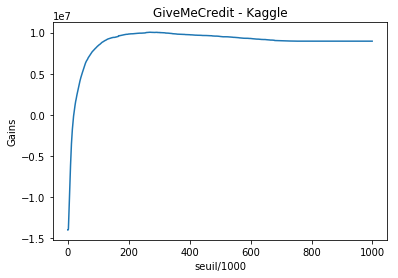

In [45]:
import matplotlib.pyplot as plt
# on fait varier le seuil de 0 à 1000 / 1000 => 0.0001 , 0.0002 ... 1 dans la fonction seuil => gain
table = [cost_threshold(n/1000) for n in range(0,1000)]
plt.xlabel("seuil/1000")
plt.ylabel("Gains")
plt.title("GiveMeCredit - Kaggle")

plt.plot(table)

max_val = max(table)
max_threshold = table.index(max_val)/1000
print(f'gain max {max_val} $ | Seuil {max_threshold}')

## calcul de l'AUC : 
#### comparaison des 1 probability de chaque positif(output = 1) avec chaque négatif(output = 0)

In [49]:
pos = prediction.loc[prediction['SeriousDlqin2yrs'] == 1] # Tout les Positif 
neg = prediction.loc[prediction['SeriousDlqin2yrs'] == 0] # Tout les negatifs 
x = 0
y = 0
# pour chaque 1 proba ( P ) dans toutes les 1 proba (P)
for threshold_pos in pos['1 probability']:
# pour chaque 1 Proba ( N ) dans toutes les 1 proba ( N )
    for threshold_neg in neg['1 probability']:
        if threshold_pos > threshold_neg:
            x += 1 
        y += 1 
print(x/y)


0.8570815719693863
